In [171]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import json

from smooth import smoothen


%matplotlib inline

In [172]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

experiemntal parameters:

v(0): hit/miss, +1 for hit, -1 for miss

v(1): stimulus intensity

v(2): rest of variance

In [173]:
def preprocessing(filename, time='full', windows=None, z_score=True, smooth=True, bl=True, csum=True):
    '''
    Preprocesses the data according to specified parameters
    
    filename: string, specifies file to use
    z_score: bool, whether to z-score the data
    smooth: bool, if true data gets smoothed
    bl: bool, if true standard baseline subtraction occurs, if false it does not
    csum: if true the cumulative sum of the signal is used which is equivalent to taking the integral
    
    returns: Preprocessed data, meta
    '''
    
    f = h5py.File(filename+'.hdf5', 'r')
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    #load data from specified file and get a boolean mask that masks the invalid dendrites as False

    data = f['data'][:, motion_mask, :]
    meta = f['meta']
    #apply mask
        
    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    if bl:
        data = data - baseline
    #subtract baseline
    
    if smooth:
        #if we smoothen the data
        if csum:
            data_pass = np.cumsum(smoothen(filename)[:,motion_mask,:], axis=2)
        else:
            data_pass = smoothen(filename)[:,motion_mask,:]
    else:
        #keep all times
        if not leak:
            data_pass = np.cumsum(data[:], axis=2)
        else:
            data_pass = cumsum_plus(data[:], tau=leak)
    meta_pass = meta[:]
    #smooth if kwarg is set, take cumsum(integral) if option is set
        
    if z_score:
        #z_score signal
        mns = np.mean(data_pass, axis=0)
        try:
        #specify exception
            mns = np.mean(mns, axis=1)
        except:
            print('Exception triggered')
            
        try:
            stds = np.std(data_pass, axis=(0,2))
        except:
            print('Exception triggered')
            
        mns = np.transpose(np.tile(mns, (data.shape[0], data.shape[2], 1)), axes=[0,2,1])
        stds = np.transpose(np.tile(stds, (data.shape[0], data.shape[2], 1)), axes=[0,2,1])
        
        data_pass = data_pass - mns
        data_pass = data_pass/stds
    #get standard deviations and means and use them to normalize the data if option is set (it should be)
            
    return meta_pass, data_pass

In [174]:
def get_betas(meta, data):
    '''
    Computes regression coefficients for each dendrite, timepoint and condition according to Mante/Sussillo
    meta: meta matrix from dataset
    data: preprocessed data matrix from dataset
    
    returns: regression coefficient matrix of shape n_dendrites x n_times x 3
    '''
    n_trials = data.shape[0]
    n_units = data.shape[1]
    n_times = data.shape[2]
    
    F_i = np.ones((3, n_trials))
    F_i[0, :] = meta[:, 2]
    F_i[1, :] = meta[:, 1]
    #F-matrix as according to Mante/Sussillo
    
    beta = np.zeros((n_units, n_times, 3))
    F_fac = np.dot(np.linalg.inv(np.dot(F_i, F_i.T)), F_i)
    #(FF^T)^-1
    
    for i in range(n_units):
        for t in range(n_times):
            r_it = data[:,i,t]
            beta[i, t, :] = F_fac.dot(r_it)
    #compute betas accodring to Mante/Sussill
            
    return beta

In [175]:
def get_population_response(meta, data):
    '''
    Computes population response, averaged within conditions
    
    meta: meta matrix from dataset
    data: data matrix from dataset
    
    returns: ndarray of shape conditions x times x units
    '''
    n_units = data.shape[1]
    n_trials = data.shape[0]
    n_times = data.shape[2]
    
    stims = np.unique(meta[:,1])
    n_stims = stims.shape[0]
    
    #get mask for hit- and miss conditions
    hit_mask = meta[:, 2] == 1
    miss_mask = meta[:, 2] == 0
    
    hit_stim_masks = []
    miss_stim_masks = []
    
    #get masks for all stimulus conditions
    for stim in stims:
        stim_mask = meta[:, 1] == stim
        hit_stim_masks.append(np.logical_and(stim_mask, hit_mask))
        miss_stim_masks.append(np.logical_and(stim_mask, miss_mask))
        
    n_conditions = len(hit_stim_masks) + len(miss_stim_masks)

    x = np.zeros((n_conditions, n_times, n_units))
    #CONVENTION: all hit, then all miss
    
    for i in range(n_conditions):
        if i < len(hit_stim_masks):
            x[i, :, :] = np.mean(data[hit_stim_masks[i]], axis=0).T
        else:
            j = i%len(hit_stim_masks)
            x[i, :, :] = np.mean(data[miss_stim_masks[j]], axis=0).T
    #compute means within conditions
            
    return x

In [176]:
def build_X_PCA(meta, data):
    '''
    Computes matrix to use in initial PCA (by putting the all times and conditions in one dimension for all dendrites)
    
    meta: meta matrix fropm dataset
    data: preprocessed data matrix from dataset
    
    returns: ndarray of shape n_conditions*n_times x n_dendrites
    '''
    x = get_population_response(meta, data)
    n_conds = x.shape[0]
    n_times = x.shape[1]
    n_dends = x.shape[2]
    
    X = x.reshape((n_conds*n_times, n_dends))
    
    return X

In [177]:
def scree(X):
    '''
    Computes pca-object for X
    
    X: some data matrix
    
    returns: pca-object
    '''
    pca = PCA()
    pca.fit(X)
    
    return pca

In [178]:
def do_PCA(X, n_comps=12):
    '''
    Applies PCA to X
    
    X: some data matrix
    n_comps: number of pca-components to keep
    
    returns: tuple (denoised X, pca-object)
    '''
    pca = PCA(n_components=12)
    
    #denoising, but staying in original space!
    X_pca = pca.fit_transform(X)
    
    return pca.inverse_transform(X_pca), pca

In [179]:
def get_beta_pca(beta_re, pca):
    '''
    Computes deoised beta matrix
    
    beta_re: rearranged beta-matrix n_conditions x n_times x n_dendrites
    pca: pca-object which will apply the PCA
    
    returns: denoised beta_re matrix of same shape
    '''
    
    beta_pca = np.zeros((beta_re.shape[0], beta_re.shape[1], beta_re.shape[2]))
    for i in range(beta.shape[2]):
        beta_pca[i,:,:] = pca.inverse_transform(pca.transform(beta_re[i,:,:]))
        
    return beta_pca

In [180]:
def get_beta_max(beta_pca):
    '''
    Computes regression vectors beta_max[:,i] which correspond to where beta-vectors have maximum norm
    
    beta_pca: output of get_geta_pca
    
    returns: matrix with beta_max vectors as column vectors
    '''
    beta_norms = np.linalg.norm(beta_pca, axis=2)
    t_max = np.argmax(beta_norms, axis=1)
    beta_max = np.zeros((beta_pca.shape[0], beta_pca.shape[2]))

    for i, t in enumerate(t_max):
        beta_max[i,:] = beta_pca[i, t, :]
    
    print('max times: \n choice: {} ms \n intensity: {} ms'.format(t_max[0]*17, t_max[1]*17))
    return beta_max

In [181]:
def filter_c(meta, data, hit, stim_id):
    '''
    Filters data by condition
    
    meta: meta matrix from dataset
    data: preprocessed data matrix from dataset
    hit: 0 or 1, if 1 pick onl hit trials. If None, pick all
    stims_id: int between 0 and 6, number of stimulus
    
    returns: data matrix with only trials according to specified condition
    '''
    n_trials = data.shape[0]
    
    if hit == None:
        hit_mask = np.ones(n_trials) == np.ones(n_trials)
    if hit == 1:
        hit_mask = meta[:,2] == 1
    if hit == 0:
        hit_mask = meta[:,2] == 0
    #make mask for hit/miss-trials
        
    stims = np.unique(meta[:,1])
    
    stim_mask = meta[:,1] == stims[stim_id]
    #make mask according to stimulus
    
    trials_mask = np.logical_and(hit_mask, stim_mask)
    #combine these
    
    return data[trials_mask]

In [182]:
meta, data = preprocessing(filelist[2], time='full', z_score=True, smooth=True, bl=True, csum=False)
#presprocess

In [183]:
beta = get_betas(meta, data)
beta_re = np.transpose(beta, axes=(2,1,0))
#get and rearrange regression coefficients according to paper

In [184]:
x = get_population_response(meta, data)

In [185]:
X = build_X_PCA(meta, data)
#make matrix to be used for PCA

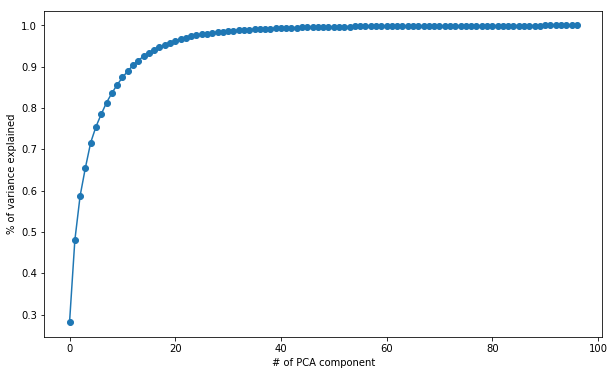

In [186]:
pca = scree(X)

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('# of PCA component')
plt.ylabel('% of variance explained')

In [187]:
n_comps = 12
X_pca, pca = do_PCA(X, n_comps=n_comps)
#denoise

In [188]:
beta_pca = get_beta_pca(beta_re, pca)
#apply PCA to regression coefficient vectors

In [189]:
beta_max = get_beta_max(beta_pca)[:2,:]
#get the regression vectors 2/ max. norm

max times: 
 choice: 2992 ms 
 intensity: 2975 ms


In [190]:
a = beta_max[0,:]
b = beta_max[1,:]

#a and b are these vectors

In [191]:
Q, R = np.linalg.qr(beta_max.T)
#Q-R decomposition to orthogonalize a and b

In [192]:
b_1 = Q[:,0]
b_2 = Q[:,1]
#orthogonalized betas

In [193]:
X_ = []
for i in range(14):
    X_.append(x[i])
#get population response for individual conditions

In [194]:
choice = []
intensity = []
for i in range(14):
    choice.append(np.dot(b_1, X_[i].T))
    intensity.append(np.dot(b_2, X_[i].T))
#projecto population response for each condition into new coordiante system

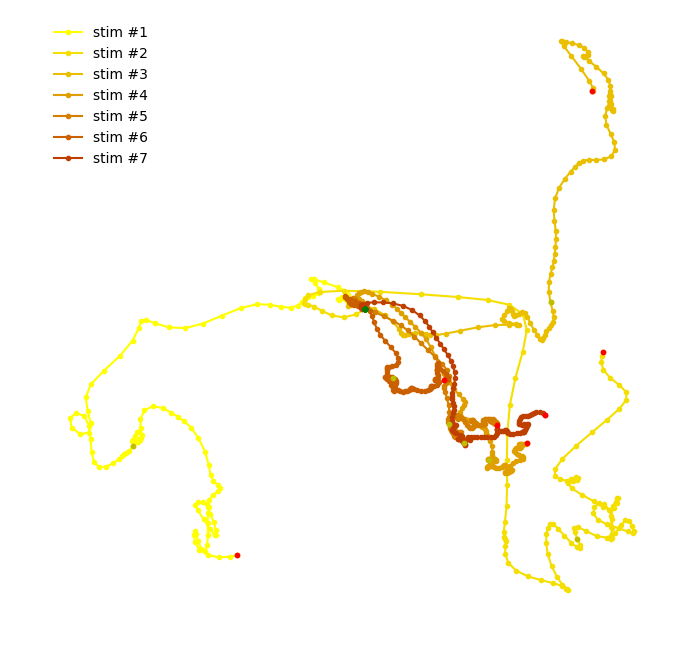

In [196]:
x_ground = choice[0][58]
y_ground = intensity[0][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]

#plt.figure(figsize=(8,8), dpi=100, frameon=False)
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
ax.axis('off')
for i in range(7):
    c = i
    
    diffx = choice[i][58] - x_ground
    diffy = intensity[i][58] - y_ground
    
    plt.plot(choice[c][58:]-diffx, intensity[c][58:]-diffy, marker='o', markersize=3, color=colors[i], zorder=1, label='stim #{}'.format(i+1))
    plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
    
    plt.legend(frameon=False)

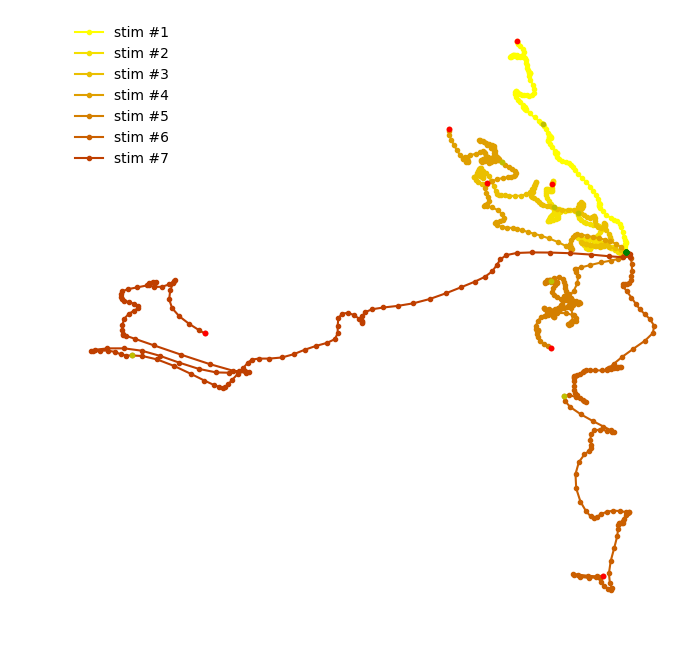

In [197]:
x_ground = choice[7][58]
y_ground = intensity[7][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]

#plt.figure(figsize=(8,8), dpi=100)
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
ax.axis('off')
for i in range(7):
    i = i+7
    c = i
    
    diffx = choice[i][58] - x_ground
    diffy = intensity[i][58] - y_ground
    
    plt.plot(choice[c][58:]-diffx, intensity[c][58:]-diffy, marker='o', markersize=3, color=colors[i-7], zorder=1, label='stim #{}'.format(i-6))
    plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
    
    plt.legend(frameon=False)

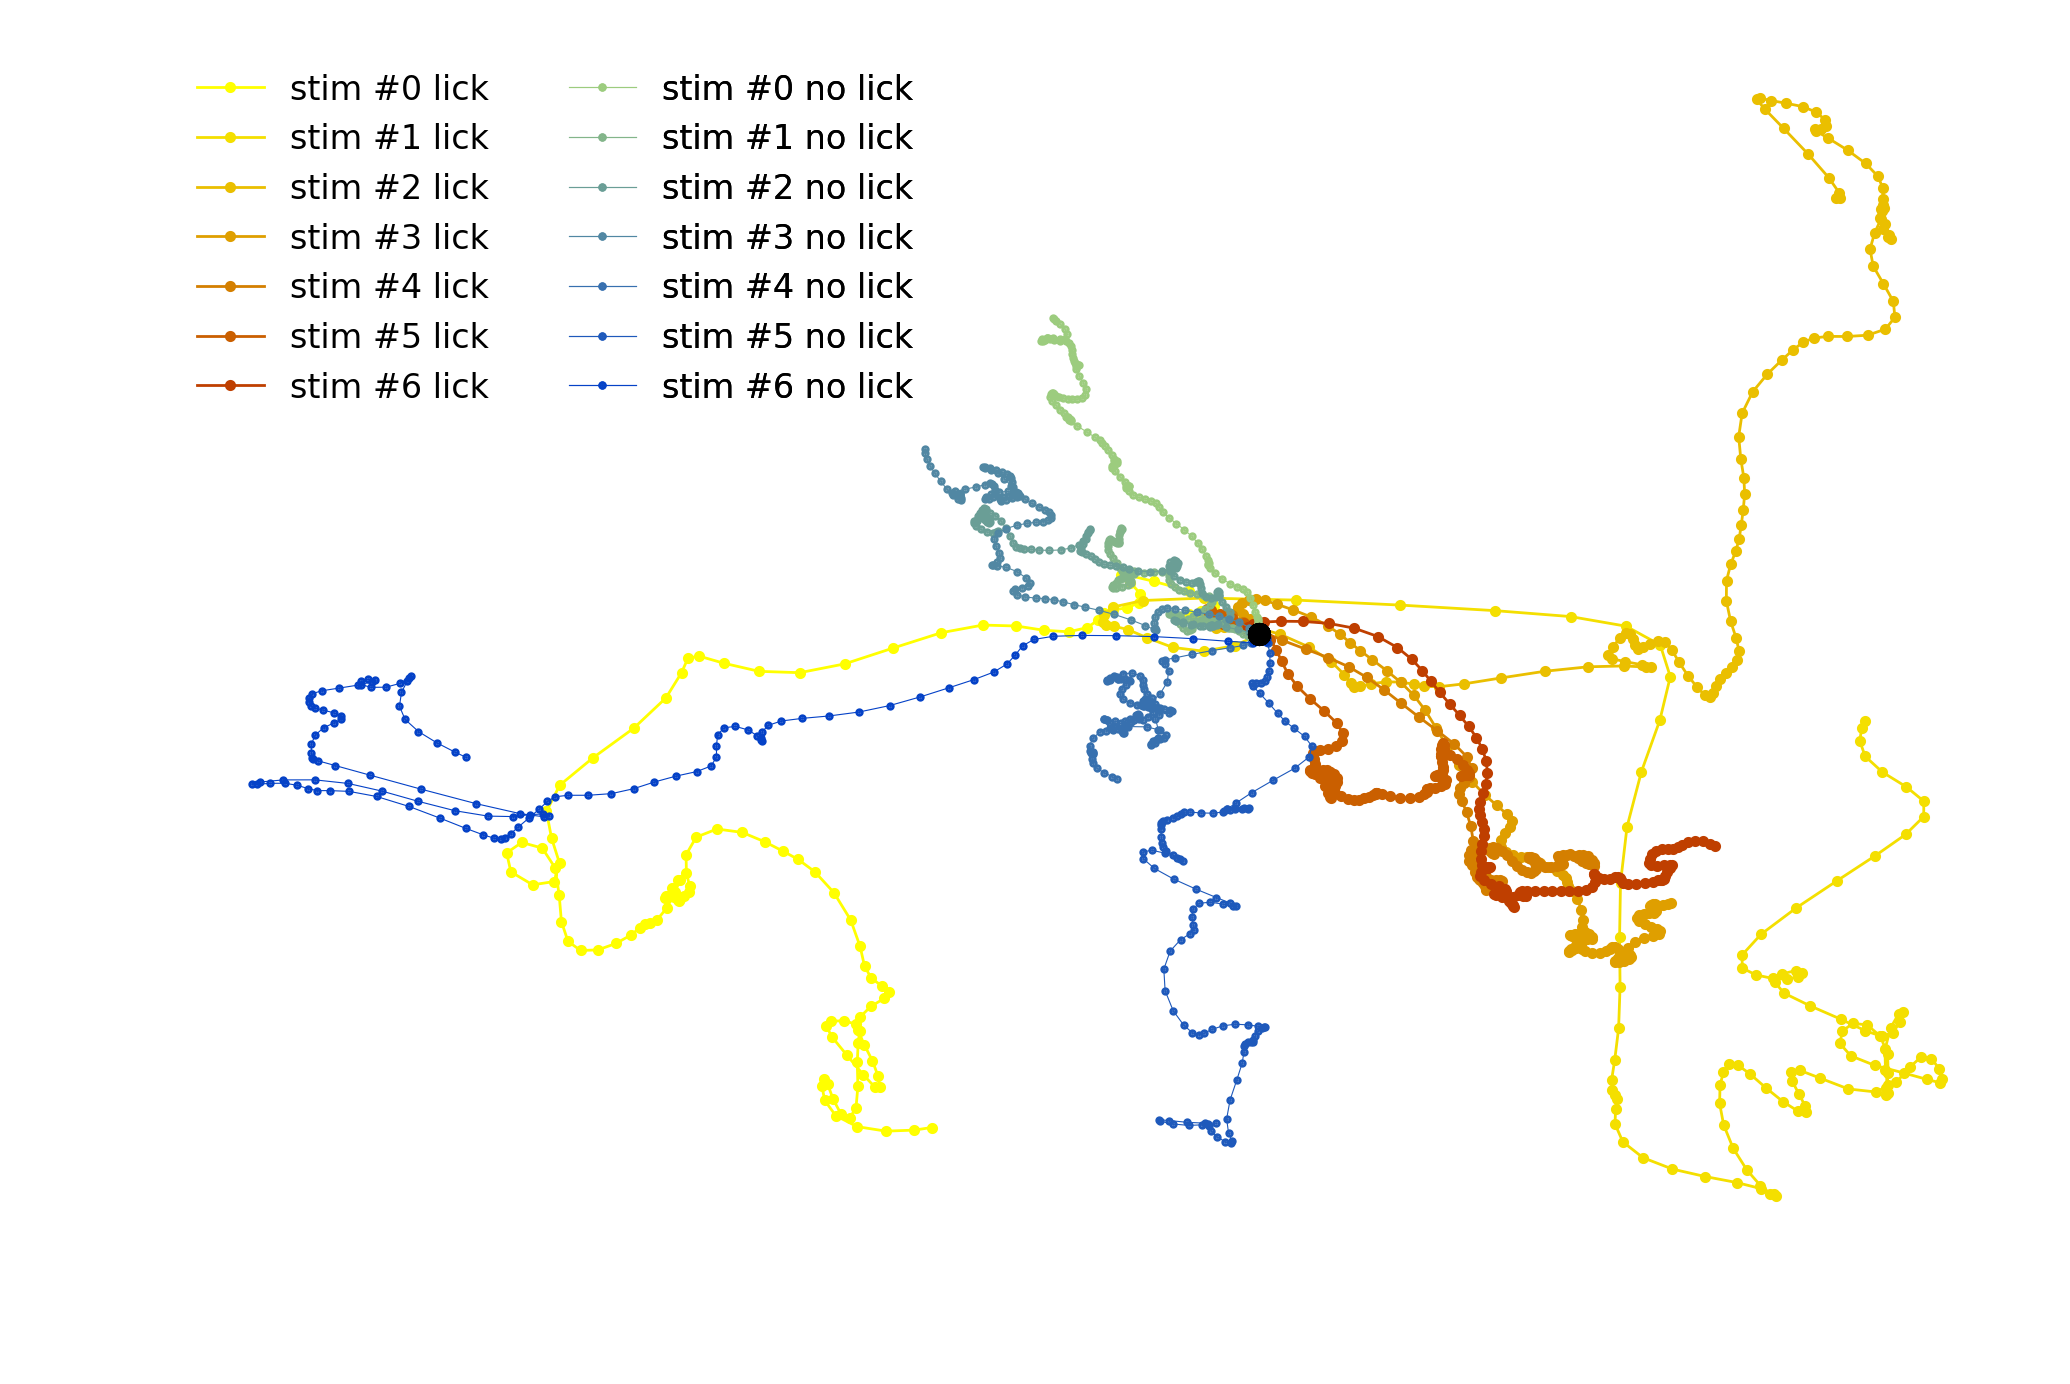

In [198]:
x_ground = choice[0][58]
y_ground = intensity[0][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]
colors_m = ['#0542C7', '#1E59BB', '#3770AF', '#5187A3', '#6A9E96', '#83B58A', '#9CCC7E'][::-1]

#plt.figure(figsize=(8,8), dpi=100, frameon=False)
fig, ax = plt.subplots( dpi=400)
ax.axis('off')
hit_labels = []
miss_labels = []
for i in range(7):
    c = i
    d = i+7
    
    diffx = choice[i][58] - x_ground
    diffy = intensity[i][58] - y_ground
    
    diffxx = choice[i+7][58] - x_ground
    diffyy = intensity[i+7][58] - y_ground
    
    #diffx = 0
    #diffy = 0
    #diffxx = 0
    #diffyy = 0
    
    #a = avs[i] != 0
    
    #plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, marker='x', zorder=4, color='black', s=8)
    #plt.scatter(choice[d][116]-diffxx, intensity[d][116]-diffyy, marker='x', zorder=4, color='black', s=8)

    h, = plt.plot(choice[c][58:]-diffx, intensity[c][58:]-diffy, marker='o', linewidth=0.5, markersize=1, color=colors[i], zorder=1, label='stim #{} lick'.format(i))
    #plt.scatter(choice[c][58:]-diffx, intensity[c][58:]-diffy, s=avs[i][58:]**2, edgecolor='none', color=colors[i], alpha=0.3, zorder=1)
    #plt.scatter(choice[d][58:]-diffxx, intensity[d][58:]-diffyy, s=avs[d][58:]**2, edgecolor='none', color=colors_m[i], alpha=0.3, zorder=1)
    m, = plt.plot(choice[d][58:]-diffxx, intensity[d][58:]-diffyy, marker='o', linewidth=0.2, markersize=0.5, color=colors_m[i], zorder=2, label='stim #{} no lick'.format(i))
    hit_labels.append('stim #{} lick'.format(i))
    miss_labels.append('stim #{} no lick'.format(i))
    
    plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='black', s=10, zorder=5)

    #plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    #plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    #plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
#first_legend = plt.legend(hits[0],['asd', 'as', 'a', 'a', 'a', 'a,', 'a'])
#plt.legend(hits[0] for h in hits)
#plt.gca().add_artist(first_legend)
#plt.plot(xx,yy)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0,2,4, 6, 8, 10, 12]], hit_labels, loc=2, fontsize=6)
legend2 = plt.legend([lines[i] for i in [1,3,5, 7, 9, 11, 13]], miss_labels, loc=2, fontsize=6, bbox_to_anchor=[0.2,1])
ax.add_artist(legend1)
ax.add_artist(legend2)
legend1.set_frame_on(False)
legend2.set_frame_on(False)

fig.savefig('reg.png')

Below here is single trial stuff, I left it in just in case, but I didn't comment it

In [155]:
beta_tilde = np.zeros((2, beta_pca.shape[1], beta_pca.shape[2]))
for t in range(beta_pca.shape[1]):
    beta_tilde[0, t, :] = beta_max[0]
    beta_tilde[1, t, :] = beta_pca[1, t, :]

In [156]:
Q_tot = np.zeros((beta_tilde.shape[2], beta_tilde.shape[0], beta_tilde.shape[1]))
for t in range(beta_tilde.shape[1]):
    Q_tilde, R_tilde = np.linalg.qr(beta_tilde[:,t,:].T)
    Q_tot[:,:,t] = Q_tilde

In [157]:
b_1_tilde = Q_tot[:,0,:]
b_2_tilde = Q_tot[:,1,:]

In [158]:
choice_tilde = []
intensity_tilde = []
for i in range(14):
    c_t = np.zeros(b_1_tilde.shape[1])
    i_t = np.zeros(b_1_tilde.shape[1])
    for t in range(b_1_tilde.shape[1]):
        c_t[t] = np.dot(b_1_tilde[:,t], X_[i][t].T)
        i_t[t] = np.dot(b_2_tilde[:,t], X_[i][t].T)
    choice_tilde.append(c_t)
    intensity_tilde.append(i_t)

In [159]:
i_new = np.vstack(intensity)
c_new = np.vstack(choice)
it_new = np.vstack(intensity_tilde)
ct_new = np.vstack(choice_tilde)

In [160]:
i_var = np.zeros(i_new.shape[1])
it_var = np.zeros(i_new.shape[1])
c_var = np.zeros(i_new.shape[1])
ct_var = np.zeros(i_new.shape[1])
for t in range(i_new.shape[1]):
    i_var[t] = np.var(i_new[:,t])
    c_var[t] = np.var(c_new[:,t])
    it_var[t] = np.var(it_new[:,t])
    ct_var[t] = np.var(ct_new[:,t])

In [162]:
hitmiss = 1
stim_id = 1
data_new = filter_c(meta, data, hitmiss, stim_id)

In [163]:
ind = (1 - hitmiss)*7 + stim_id
sn = single[ind]

In [164]:
D_ = []
for i in range(data_new.shape[0]):
    D_.append(data_new[i])

In [165]:
choice_new = []
intensity_new = []
for i in range(data_new.shape[0]):
    choice_new.append(np.dot(b_1, D_[i]))
    intensity_new.append(np.dot(b_2, D_[i]))

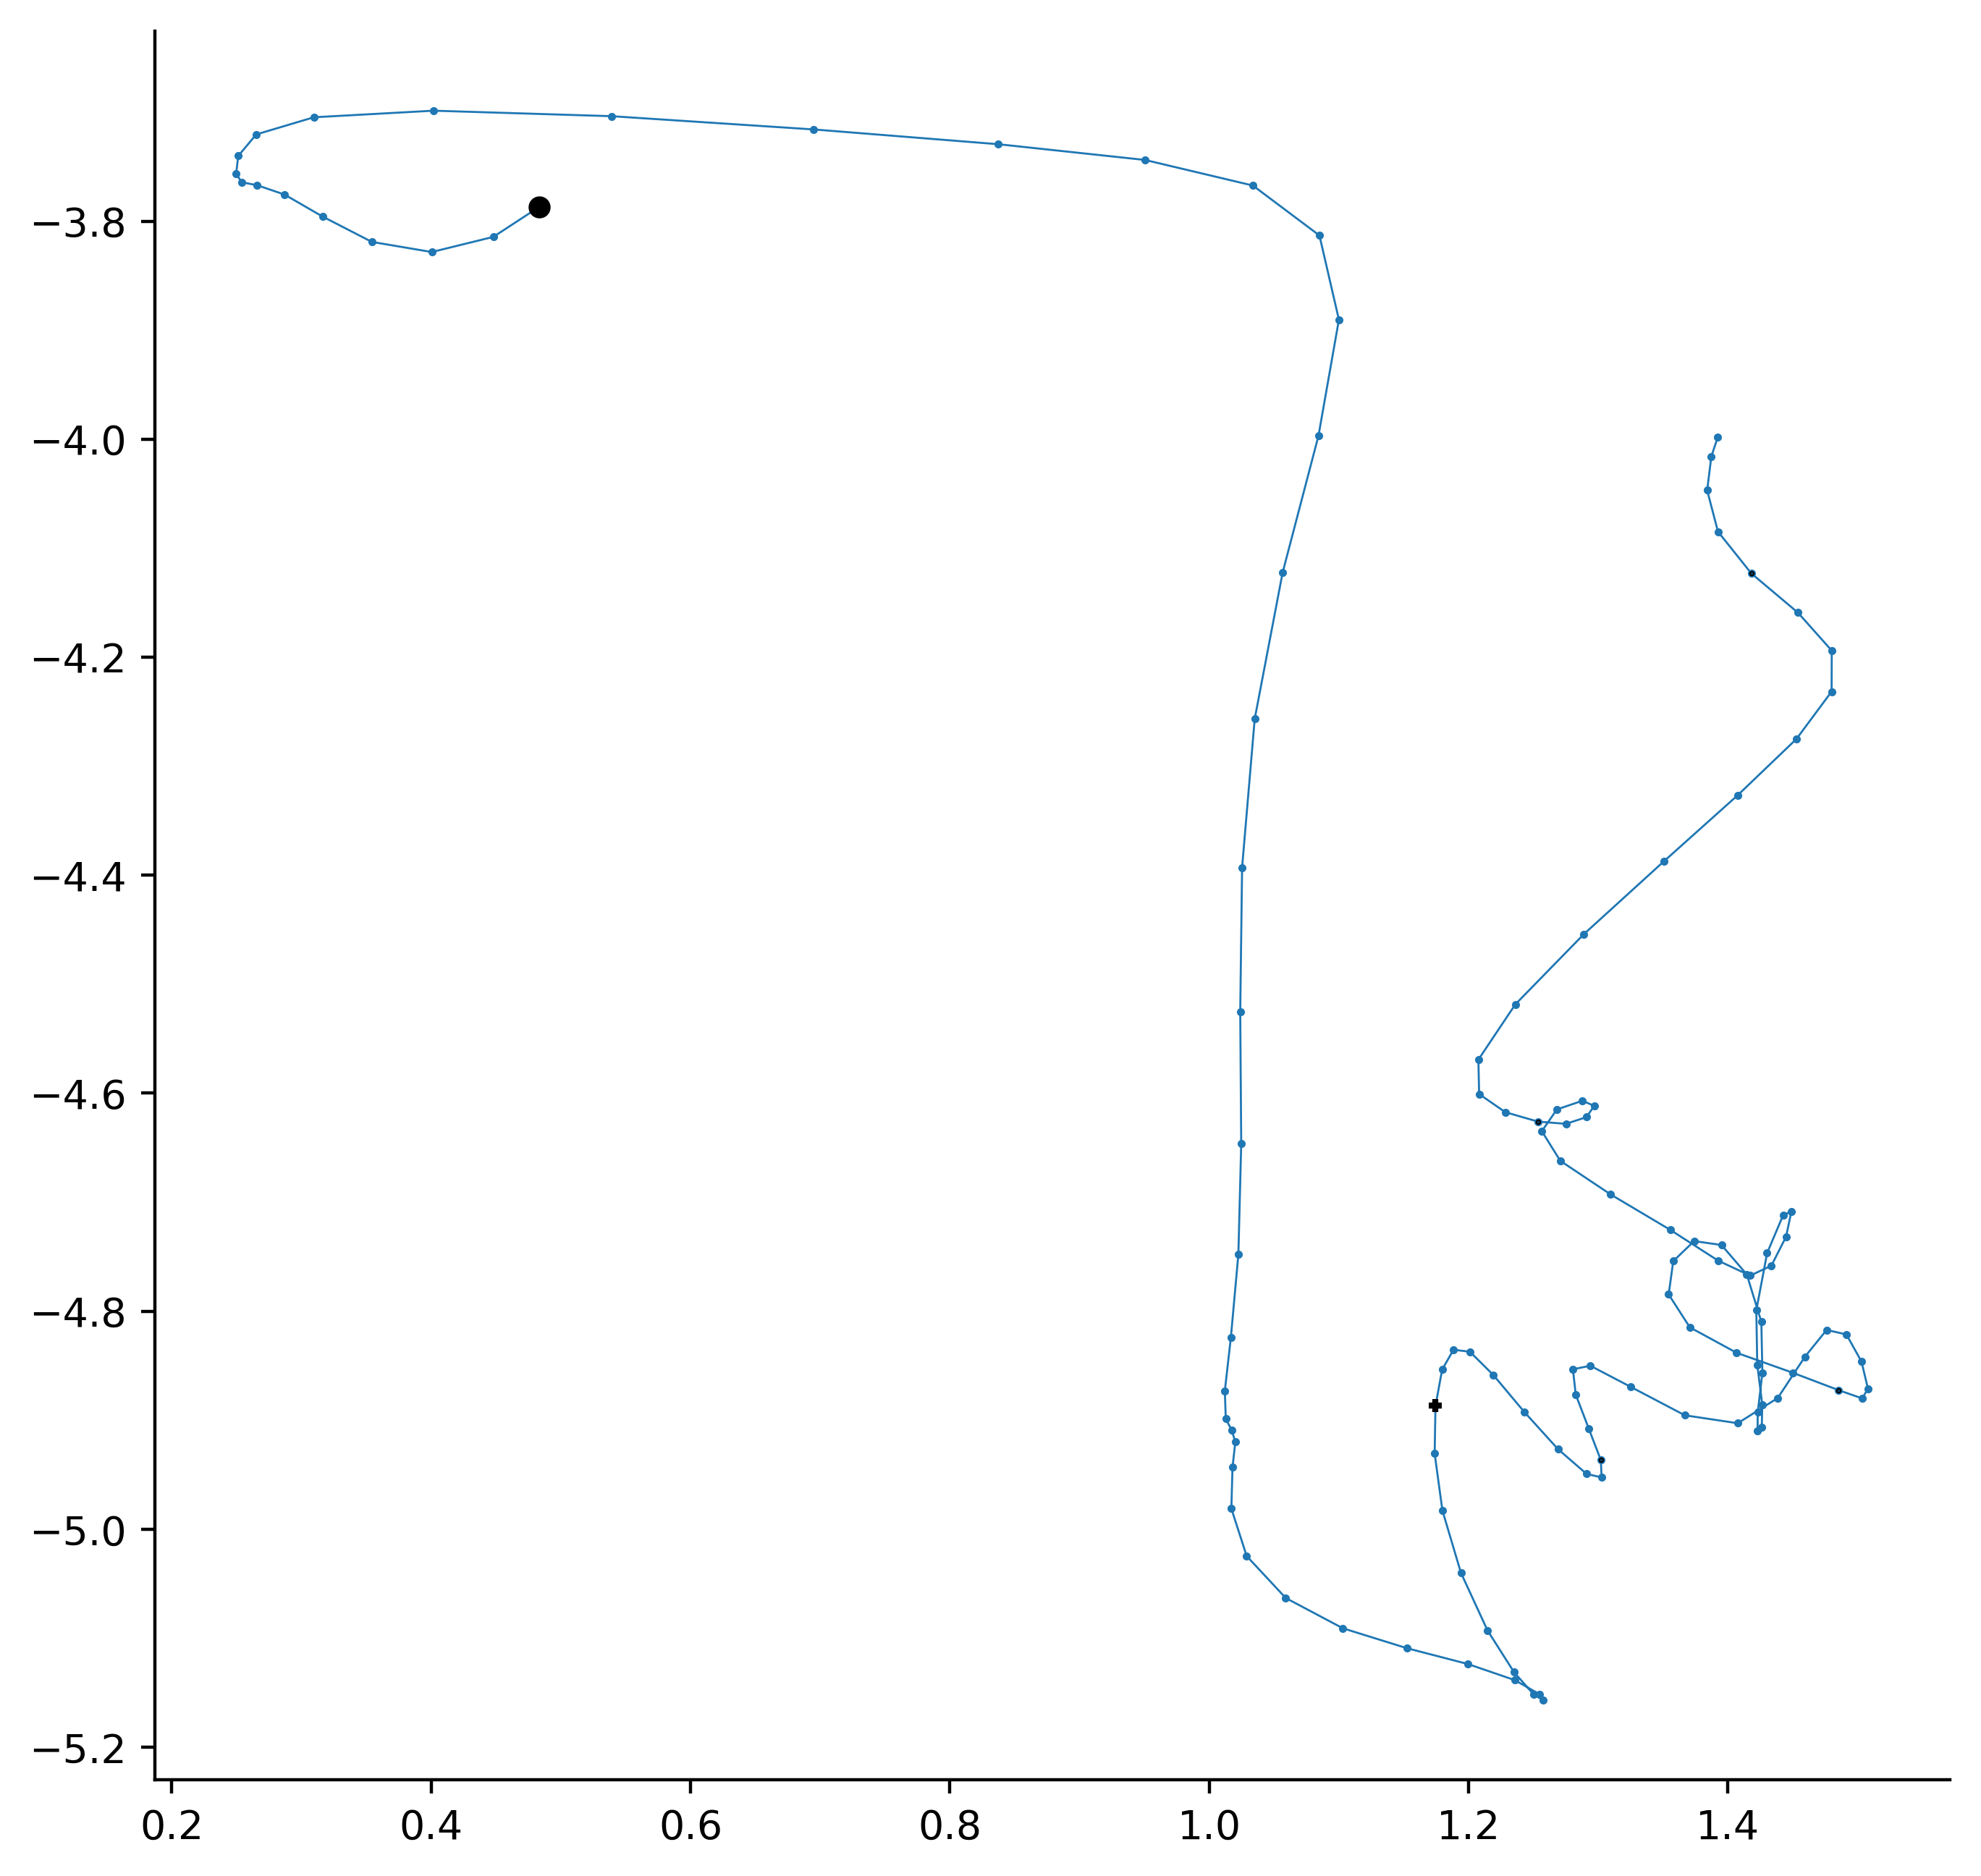

In [166]:
x_ground = choice_new[0][58]
y_ground = intensity_new[0][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]
colors_m = ['#0542C7', '#1E59BB', '#3770AF', '#5187A3', '#6A9E96', '#83B58A', '#9CCC7E'][::-1]

#plt.figure(figsize=(8,8), dpi=100, frameon=False)
fig, ax = plt.subplots(figsize=(8,8), dpi=400)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
hit_labels = []
miss_labels = []
for i in range(len(choice_new)):
    c = i
    
    diffx = choice_new[i][58] - x_ground
    diffy = intensity_new[i][58] - y_ground
    
    diffx = 0
    diffy = 0
    
    a = sn[i] != 0
    
    plt.scatter(choice_new[c][a][0]-diffx, intensity_new[c][a][0]-diffy, zorder=4, s=10, color='black', marker='+')
    plt.scatter(choice_new[c][a]-diffx, intensity_new[c][a]-diffy, zorder=4, s=.5, color='black', marker='.')
    h, = plt.plot(choice_new[c][58:]-diffx, intensity_new[c][58:]-diffy, marker='o', linewidth=0.5, markersize=1, zorder=1, label='stim #{} hit'.format(i+1))
    hit_labels.append('stim #{} hit'.format(i+1))
    miss_labels.append('stim #{} miss'.format(i+1))
    #plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    #plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    #plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
#first_legend = plt.legend(hits[0],['asd', 'as', 'a', 'a', 'a', 'a,', 'a'])
#plt.legend(hits[0] for h in hits)
#plt.gca().add_artist(first_legend)
ax.scatter([x_ground], [y_ground], s=20, color='black', zorder=3)